In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random

from os import listdir
import shutil
import numpy as np
import keras.preprocessing.image as kerasImg
import keras.layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import ops


dataset = "https://www.kaggle.com/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis/data"
od.download(dataset)

datadir = "/content/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/"
os.listdir(datadir)


Dataset URL: https://www.kaggle.com/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis


100%|██████████| 874M/874M [00:13<00:00, 69.9MB/s]


['train', 'test']

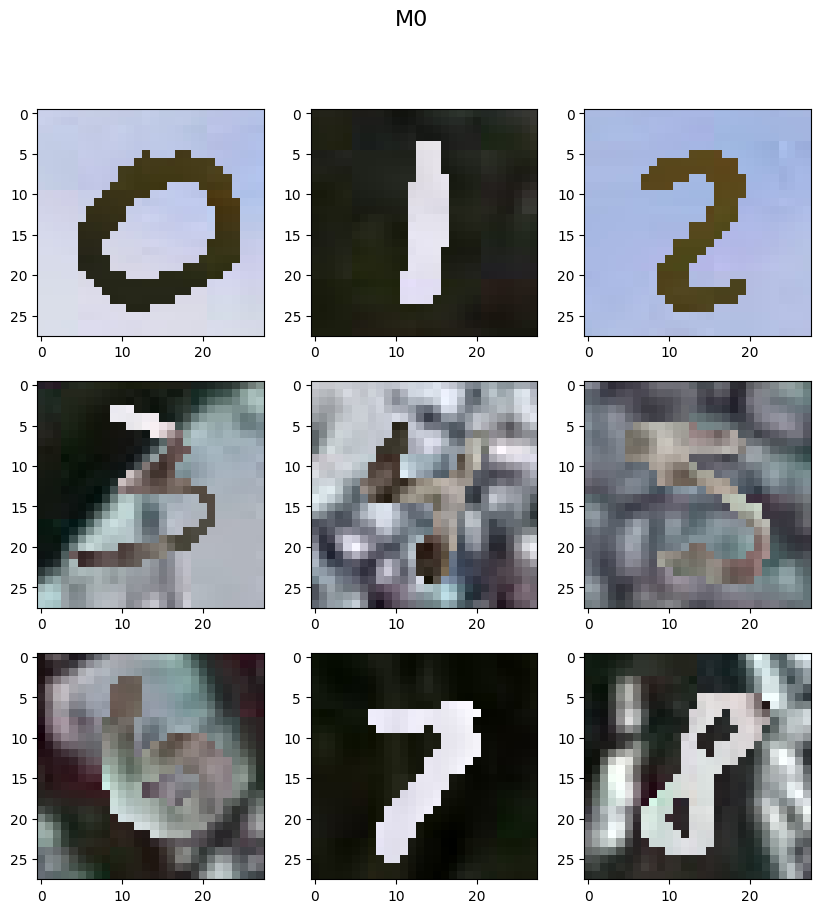

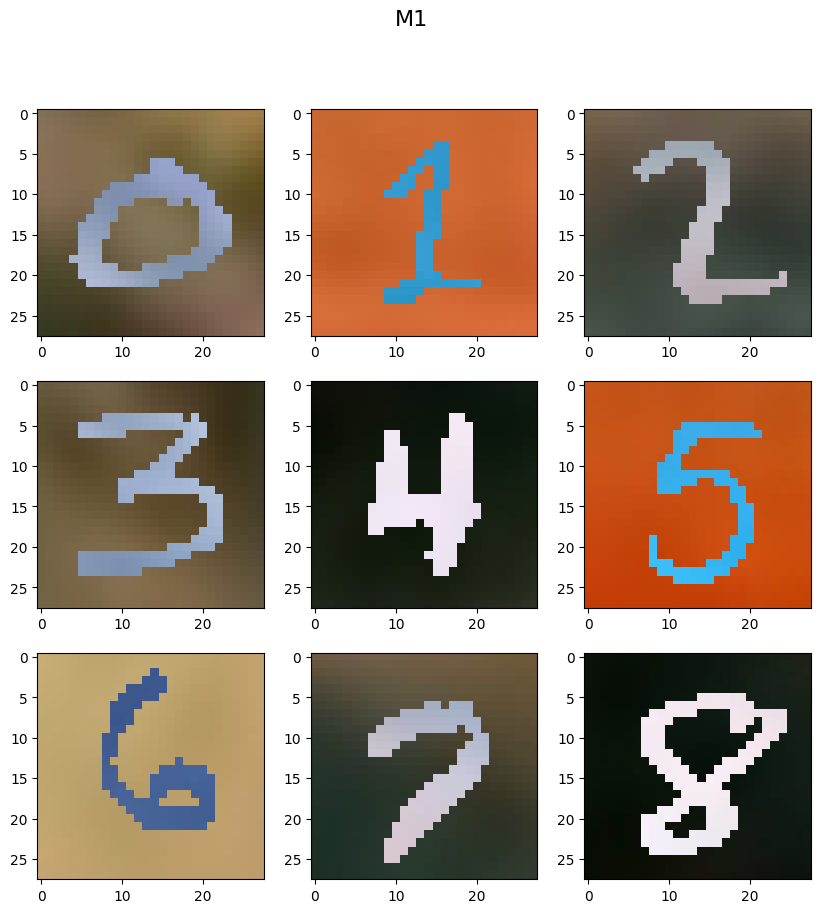

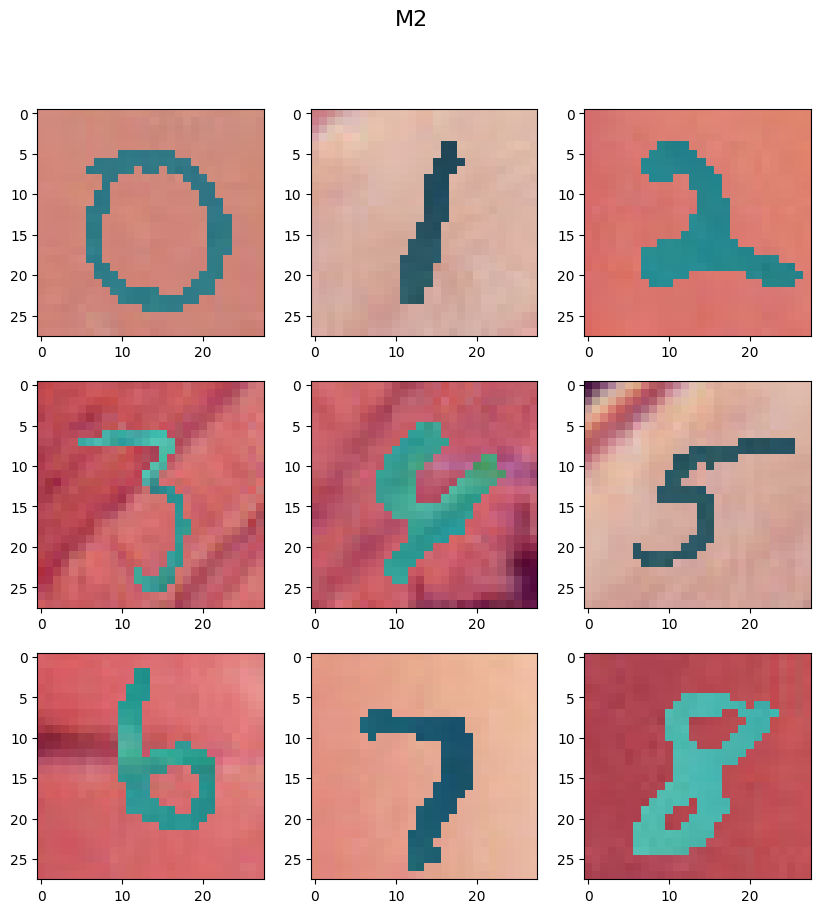

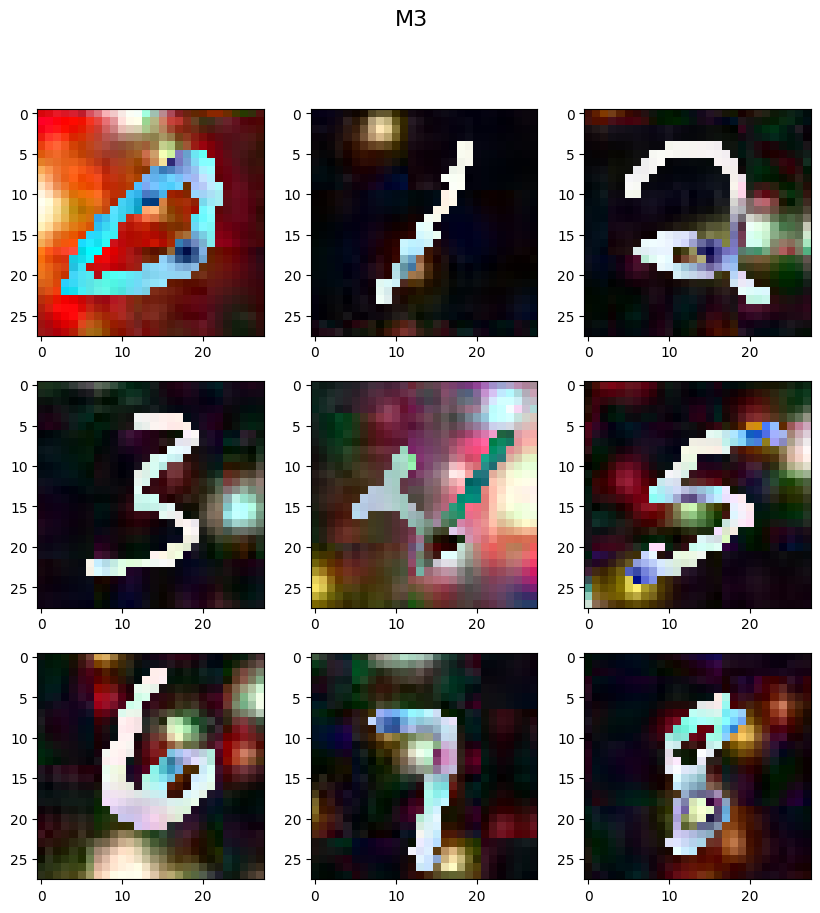

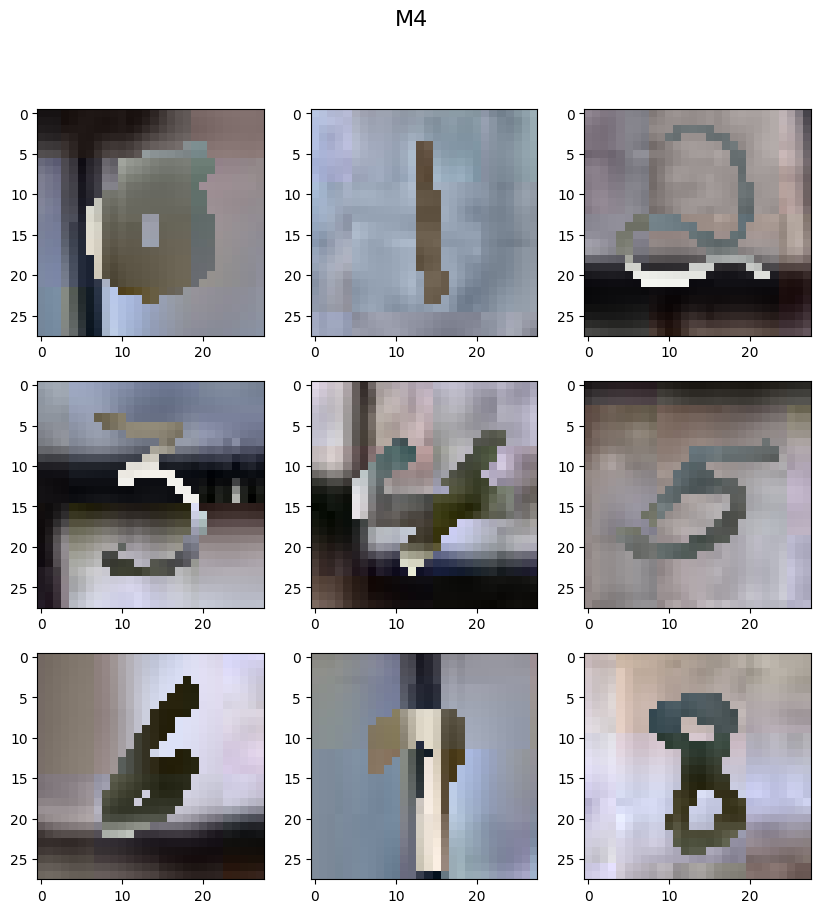

In [3]:
folder_train = datadir + "/train/"
folder_test = datadir + "/test/"

modes = ["m0", "m1", "m2", "m3", "m4"]


# Show some images on folder train, 9 for mode
for mode in modes:
  plt.figure(figsize=(10,10))
  # use mode to title
  plt.suptitle(mode.upper(), fontsize=16)
  for i in range(9):
    plt.subplot(330+1+i)
    filename = folder_train + mode + "/0." + str(i) + ".png"
    img = imread(filename)
    plt.imshow(img)
  plt.show()


Distribución de resoluciones de imágenes:
          width    height
count  300000.0  300000.0
mean       28.0      28.0
std         0.0       0.0
min        28.0      28.0
25%        28.0      28.0
50%        28.0      28.0
75%        28.0      28.0
max        28.0      28.0

Distribución de imágenes por carpeta:
folder
m0    60000
m1    60000
m2    60000
m3    60000
m4    60000
Name: count, dtype: int64


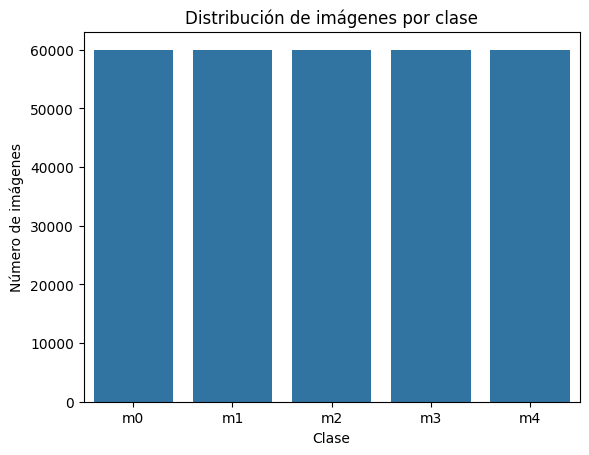

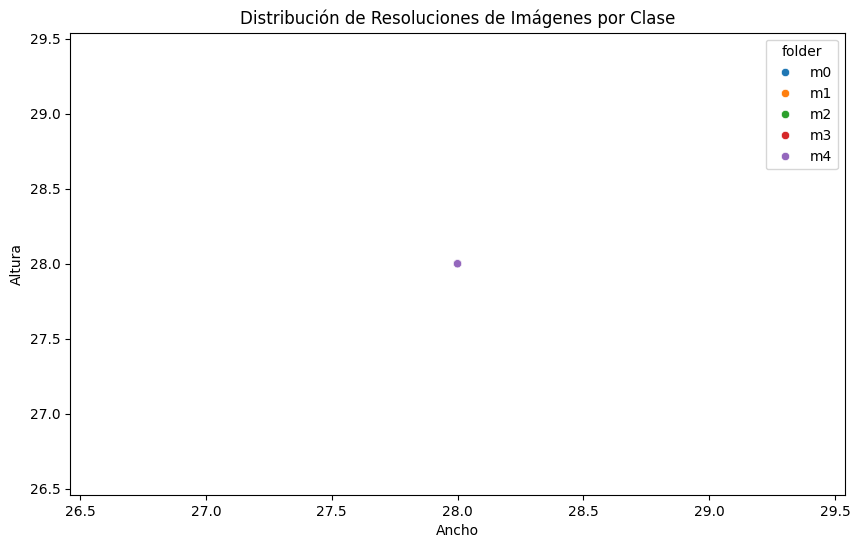

El conjunto de datos está balanceado.


In [4]:
import seaborn as sns
import cv2
# Inicializar listas para almacenar datos
image_data = []

# Recorrer cada carpeta y analizar las imágenes
for mode in modes:
    folder_path = os.path.join(folder_train, mode)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            height, width, _ = img.shape
            image_data.append({
                'folder': mode,
                'filename': img_name,
                'width': width,
                'height': height
            })

# Convertir los datos a un DataFrame de pandas
df = pd.DataFrame(image_data)

# Documentar la resolución de las imágenes
print("Distribución de resoluciones de imágenes:")
print(df[['width', 'height']].describe())

# Verificar si las imágenes están balanceadas
folder_counts = df['folder'].value_counts()
print("\nDistribución de imágenes por carpeta:")
print(folder_counts)

# Visualizar la distribución de las imágenes por carpeta
sns.barplot(x=folder_counts.index, y=folder_counts.values)
plt.title('Distribución de imágenes por clase')
plt.xlabel('Clase')
plt.ylabel('Número de imágenes')
plt.show()

# Visualizar la distribución de las resoluciones de las imágenes
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='width', y='height', hue='folder')
plt.title('Distribución de Resoluciones de Imágenes por Clase')
plt.xlabel('Ancho')
plt.ylabel('Altura')
plt.show()

# Verificar si el conjunto de datos está balanceado
if folder_counts.std() == 0:
    print("El conjunto de datos está balanceado.")
else:
    print("El conjunto de datos NO está balanceado.")

In [5]:
folder = datadir

# Subdirectorios para entrenamiento y prueba
subdirs = ['train/', 'test/']

# Subdirectorios que corresponden a las clases (m0, m1, m2, m3, m4)
labeldirs = ['m0/', 'm1/', 'm2/', 'm3/', 'm4/']

In [6]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image as kerasImg
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tensorflow import keras

# Asegúrate de que estás utilizando la GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('No se encontró GPU. Por favor, activa la GPU en Colab.')
print('GPU encontrada en:', device_name)



# Asignar etiquetas binarias a cada clase
# Por ejemplo, asignar 0 para 'm0' y 1 para todas las demás
binary_label_map = {
    'm0/': 0,
    'm1/': 1,
    'm2/': 1,
    'm3/': 1,
    'm4/': 1
}

class ImageDataGenerator(Sequence):
    def __init__(self, directory, labeldirs, label_map, batch_size=32, target_size=(200, 200), shuffle=True):
        self.directory = directory
        self.labeldirs = labeldirs
        self.label_map = label_map
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.image_paths, self.labels = self._load_image_paths_and_labels()
        self.on_epoch_end()

    def _load_image_paths_and_labels(self):
        image_paths = []
        labels = []
        for dir in self.labeldirs:
            dir_path = os.path.join(self.directory, dir)
            for file in os.listdir(dir_path):
                img_path = os.path.join(dir_path, file)
                image_paths.append(img_path)
                labels.append(self.label_map[dir])
        return image_paths, labels

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        for img_path in batch_image_paths:
            imagen = kerasImg.load_img(img_path, target_size=self.target_size)
            imagen = kerasImg.img_to_array(imagen)
            images.append(imagen)
        return np.array(images), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.image_paths))
            np.random.shuffle(indices)
            self.image_paths = np.array(self.image_paths)[indices]
            self.labels = np.array(self.labels)[indices]

# Crear instancias del generador de datos
train_generator = ImageDataGenerator(os.path.join(folder, subdirs[0]), labeldirs, binary_label_map, batch_size=32)
test_generator = ImageDataGenerator(os.path.join(folder, subdirs[1]), labeldirs, binary_label_map, batch_size=32)

# Definir el modelo
modelo1 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
modelo1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
modelo1.summary()

# Entrenar el modelo
history = modelo1.fit(train_generator, validation_data=test_generator, epochs=5)


GPU encontrada en: /device:GPU:0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 200, 200, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 320000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      40,960,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,961,153 (156.25 MB)

 Trainable params: 40,961,153 (156.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9375/9375 ━━━━━━━━━━━━━━━━━━━━ 321s 34ms/step - accuracy: 0.7980 - loss: 30890.7598 - val_accuracy: 0.8000 - val_loss: 0.5010
Epoch 2/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 306s 32ms/step - accuracy: 0.8011 - loss: 0.5004 - val_accuracy: 0.8000 - val_loss: 0.5007
Epoch 3/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 323s 32ms/step - accuracy: 0.8004 - loss: 0.5011 - val_accuracy: 0.8000 - val_loss: 0.5006
Epoch 4/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 303s 32ms/step - accuracy: 0.8004 - loss: 0.5007 - val_accuracy: 0.8000 - val_loss: 0.5005
Epoch 5/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 303s 32ms/step - accuracy: 0.7995 - loss: 0.5017 - val_accuracy: 0.8000 - val_loss: 0.5005


In [7]:
import json
history_path = 'history1.json'
model_save_path = 'modelo1.h5'

In [8]:
modelo1.save(model_save_path)
print(f'Modelo guardado en {model_save_path}')


with open(history_path, 'w') as f:
    json.dump(history.history, f)
print(f'Historial guardado en {history_path}')


Modelo guardado en modelo1.h5
Historial guardado en history1.json


In [9]:
# Cargar el modelo (opcional)
from tensorflow.keras.models import load_model
modelo1 = load_model(model_save_path)
print('Modelo cargado exitosamente.')
# Recompilar el modelo para tener métricas actualizadas
modelo1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
# Realizar una evaluación (opcional)
loss, accuracy = modelo1.evaluate(test_generator)
print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

with open(history_path, 'r') as f:
    history1 = json.load(f)

Modelo cargado exitosamente.
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 45s 28ms/step - accuracy: 0.8012 - loss: 0.4989
Pérdida en el conjunto de prueba: 0.5004
Precisión en el conjunto de prueba: 0.8001


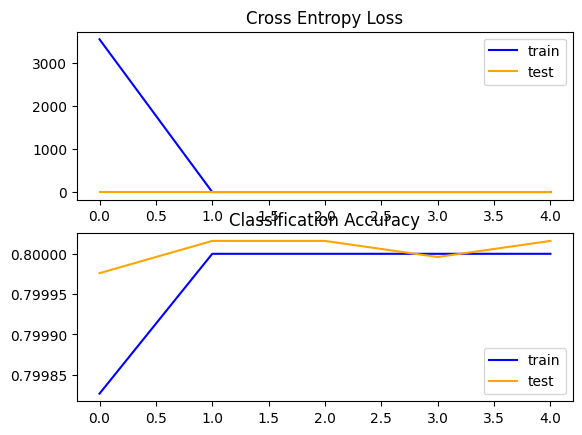

In [15]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history1['loss'], color='blue', label='train')
plt.plot(history1['val_loss'], color='orange', label='test')
plt.legend()
 # plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history1['accuracy'], color='blue', label='train')
plt.plot(history1['val_accuracy'], color='orange', label='test')
plt.legend()

plt.show()


In [11]:
# Definir el modelo
modelo2 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_uniform',padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(128,activation='relu',kernel_initializer='he_uniform'),
    keras.layers.Dense(1, activation='sigmoid'),
])

# Compilar el modelo
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
modelo2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
modelo2.summary()

# Entrenar el modelo
history = modelo2.fit(train_generator, validation_data=test_generator, epochs=5)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 200, 200, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 100, 100, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 640000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      81,920,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,956,161 (312.64 MB)

 Trainable params: 81,956,161 (312.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 446s 47ms/step - accuracy: 0.2004 - loss: nan - val_accuracy: 0.2000 - val_loss: nan
Epoch 2/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 528s 50ms/step - accuracy: 0.2002 - loss: nan - val_accuracy: 0.2000 - val_loss: nan
Epoch 3/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 501s 50ms/step - accuracy: 0.2011 - loss: nan - val_accuracy: 0.2000 - val_loss: nan
Epoch 4/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 432s 46ms/step - accuracy: 0.1994 - loss: nan - val_accuracy: 0.1999 - val_loss: nan
Epoch 5/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 449s 48ms/step - accuracy: 0.1993 - loss: nan - val_accuracy: 0.2000 - val_loss: nan


In [12]:
history2_path = 'history2.json'
model2_save_path = 'modelo2.h5'

In [16]:
modelo2.save(model2_save_path)
print(f'Modelo guardado en {model2_save_path}')


with open(history2_path, 'w') as f:
    json.dump(history.history, f)
print(f'Historial guardado en {history2_path}')


Modelo guardado en modelo2.h5
Historial guardado en history2.json


In [17]:
modelo2 = load_model(model2_save_path)
print('Modelo cargado exitosamente.')
# Recompilar el modelo para tener métricas actualizadas
modelo2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
# Realizar una evaluación (opcional)
loss, accuracy = modelo2.evaluate(test_generator)
print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

with open(history2_path, 'r') as f:
    history2 = json.load(f)

Modelo cargado exitosamente.
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.1978 - loss: nan
Pérdida en el conjunto de prueba: nan
Precisión en el conjunto de prueba: 0.2000


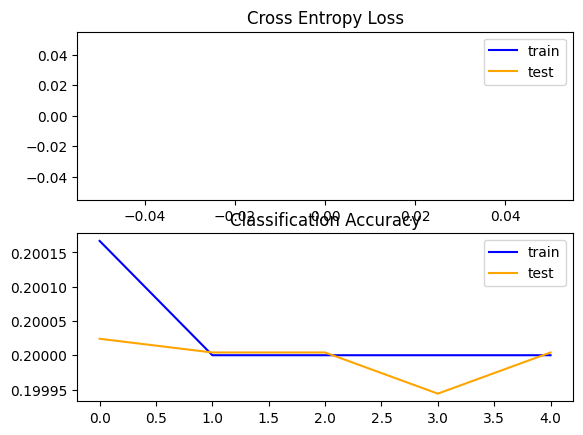

In [18]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history2['loss'], color='blue', label='train')
plt.plot(history2['val_loss'], color='orange', label='test')
plt.legend()
 # plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history2['accuracy'], color='blue', label='train')
plt.plot(history2['val_accuracy'], color='orange', label='test')
plt.legend()

plt.show()